In [1]:
%load_ext dotenv
%dotenv

In [2]:
# get raw data from GCP bucket
import sys
import numpy as np
np.set_printoptions(threshold=1000)

import pandas as pd
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
import json
import tempfile
from datetime import datetime

from google.cloud import storage

# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 50)
# pd.set_option('display.width', 100)
# pd.set_option('display.max_colwidth', -1)

# The bucket name for the location of the data is in the .env file
BUCKET_NAME = os.environ['BUCKET_NAME']
DATA_FILE = 'labeled_npi.csv'
df_pkl = pd.read_pickle("data.pkl")

In [138]:
class Preprocesser:
    def __init__(self, df):
        self.df_labels = pd.read_csv(DATA_FILE)
        self.keywords = ['incident command system',
                         'emergency operations',
                         'joint information center',
                         'social distancing',
                         'childcare closers',
                         'travel advisory',
                         'travel warning',
                         'isolation',
                         'quarantine',
                         'mass gathering cancellations',
                         'school closures',
                         'facility closures',
                         'evacuation',
                         'relocation',
                         'restricting travel',
                         'travel ban',
                         'patient cohort',
                         'npi']
        self.occurances_minimum = 1
        self.df_full = df.copy()
        print(self.df_full.shape)
        self.key_slice()
        print(self.df_full.shape)
        self.npi_slice()
        print(self.df_full.shape)
        self.df_full = self.df_full.merge(self.df_labels, on="title", how="inner")
        self.df_full = self.df_full.loc[self.df_full.isNPI.notna()]
            
    def key_slice(self):
        self.df_full = self.df_full[self.df_full['abstract'].str.contains('|'.join(self.keywords), na=False, regex=True)].reset_index(drop=True)
        
    def npi_slice(self):
        def get_count(row):
            return sum([row['abstract'].count(keyword) for keyword in self.keywords])
        self.df_full = self.df_full[self.df_full.apply(get_count, axis=1) >= self.occurances_minimum]
        
    def remove_stopwords(self,columns):
        stop = stopwords.words('english')
        for col in columns:
            self.df_full[col] = self.df_full[col].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    def to_tfidf(self,columns):
        for col in columns:
            tfidfv = TfidfVectorizer()
            self.df_full[col + '_tfidf'] = list(tfidfv.fit_transform(self.df_full[col]).toarray())
            
    def remove_punc(self, columns):
        for col in columns:
            self.df_full[col] = self.df_full[col].str.replace('[^a-zA-Z\s]+','')
        
def display_wordcloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()



In [139]:
def pca_apply(df, columns, n_comp):
    new_df = df.copy()
    for col in columns:
        pca = PCA(n_components=n_comp)
        new_df[col+'_pca'] = list(pca.fit_transform(np.stack(df[col].to_numpy())))
    return new_df

def apply_scaler(df, columns):
    new_df = df.copy()
    for col in columns:
        scaler = StandardScaler()
        new_df[col + '_scaled'] = list(scaler.fit_transform(np.stack(df[col].to_numpy())))
    return new_df


In [140]:
data_obj = Preprocesser(df_pkl)

(1612, 6)
(1612, 6)
(1612, 6)


In [141]:
data_obj.df_full.isNPI.value_counts()

0.0    420
1.0    187
Name: isNPI, dtype: int64

In [168]:
data_obj.remove_punc(['body_text','abstract'])
data_obj.remove_stopwords(['body_text', 'abstract'])
data_obj.to_tfidf(['body_text', 'abstract'])
pca_df = pca_apply(data_obj.df_full, ['abstract_tfidf','body_text_tfidf'], 10)
scaled_df = apply_scaler(pca_df,['abstract_tfidf_pca','body_text_tfidf_pca'])

In [169]:
scaled_df.columns

Index(['paper_id', 'title', 'author_list', 'abstract', 'body_text', 'doi',
       'Unnamed: 0', 'Unnamed: 0.1', 'isNPI', 'body_text_tfidf',
       'abstract_tfidf', 'abstract_tfidf_pca', 'body_text_tfidf_pca',
       'abstract_tfidf_pca_scaled', 'body_text_tfidf_pca_scaled'],
      dtype='object')

In [170]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [186]:
X = np.stack(scaled_df["body_text_tfidf_pca_scaled"].to_numpy())
y = scaled_df["isNPI"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [187]:
dtrain.num_row()

485

In [188]:
dtest.num_row()

122

In [189]:
from sklearn.metrics import f1_score

In [190]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['eval_metric'] = ['auc']

In [176]:
# num_round = 200
# evallist = [(dtest, 'eval'), (dtrain, 'train')]
# bst = xgb.train(param, dtrain, num_round, evallist)

In [191]:
clf_xgb = xgb.XGBClassifier(max_depth=6, learning_rate=0.1,silent=False, objective='binary:logistic', \
                      booster='gbtree', n_jobs=8, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, \
                      subsample=0.8, colsample_bytree=0.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1)

clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=8, nthread=8, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, silent=False, subsample=0.8,
       tree_method=None, validate_parameters=False, verbosity=None)

In [192]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
y_pred = clf_xgb.predict(X_test)
precision_recall_fscore_support(y_test, y_pred, average='macro')

(0.8262195121951219, 0.8352130325814536, 0.830398517145505, None)

In [193]:
accuracy_score(y_test, y_pred)

0.8524590163934426

In [194]:
core_booster = clf_xgb.get_booster()

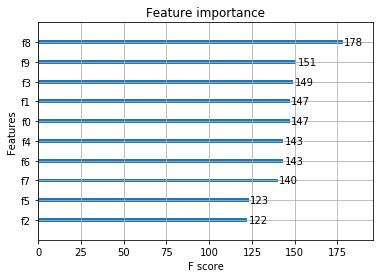

In [195]:
xgb.plot_importance(core_booster)


In [199]:
from sklearn.metrics import plot_roc_curve

ImportError: cannot import name 'plot_roc_curve'